In [1]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari
from pathlib import Path

In [14]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d import job as jb
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

from suite3d import nbtools as nbui
from suite3d import extension as ext

from importlib import reload

In [3]:
tif_dir = Path('/mnt/md0/data/NaJi/GCaMP6sVS')

In [4]:
tifs = tfu.get_tif_paths(tif_dir, sort=True, natsort=True)

In [5]:
fs = 1 / 0.2385

In [6]:
job_params = {
    'faced' : True,
    'faced_nz' : 40,
    'planes' : n.arange(40),

    'subtract_crosstalk' : False,
    'fuse_strips' : False,
    'lbm' : False,

    '3d_reg' : False,
    'gpu_reg': True,

    'n_init_files' : 1,

}
    

In [7]:
# Create the job
exp_str = 'NaJi-GCaMP6sVS'
job = jb.Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/params.npy


In [8]:
job.params['voxel_size_um'] = (5, 2, 1.4)

In [9]:
# job.run_init_pass()

In [40]:
summary = job.load_summary()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f677aa4dd90>)

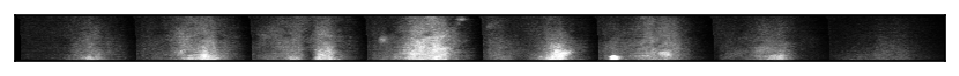

In [58]:
tfu.show_tif(summary['ref_img_3d'][:, 250], vminmax_percentile=(0,99.9))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f6732be49a0>)

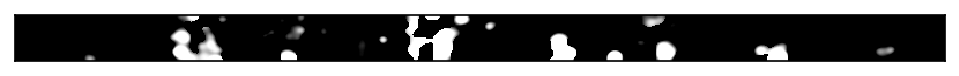

In [66]:
tfu.show_tif(corr_map_thresh[:, 250], vminmax=(0.15,0.3))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f67a8c58be0>)

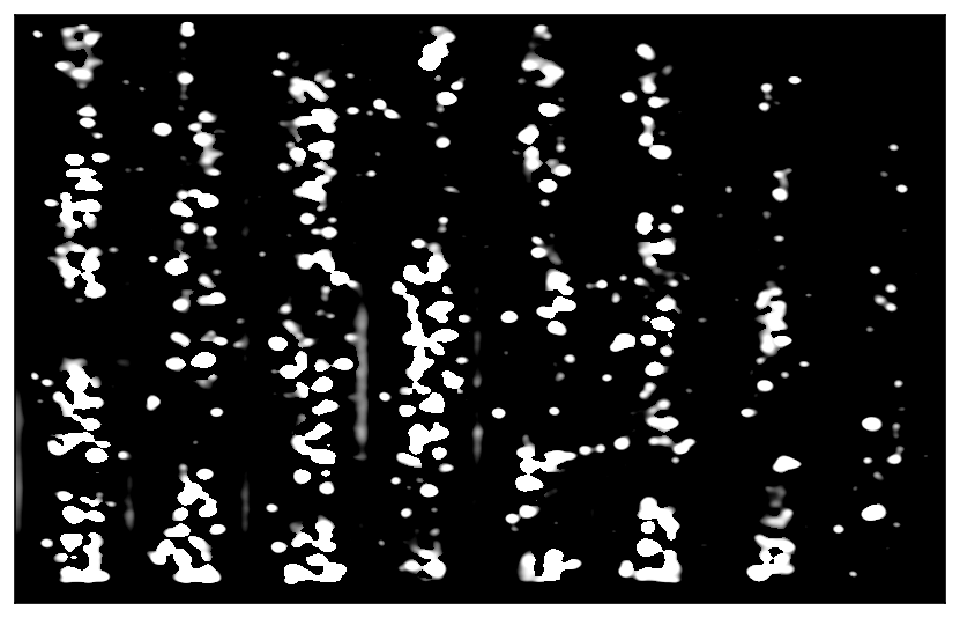

In [65]:
tfu.show_tif(corr_map_thresh[30], vminmax=(0.15,0.3))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f673189f310>)

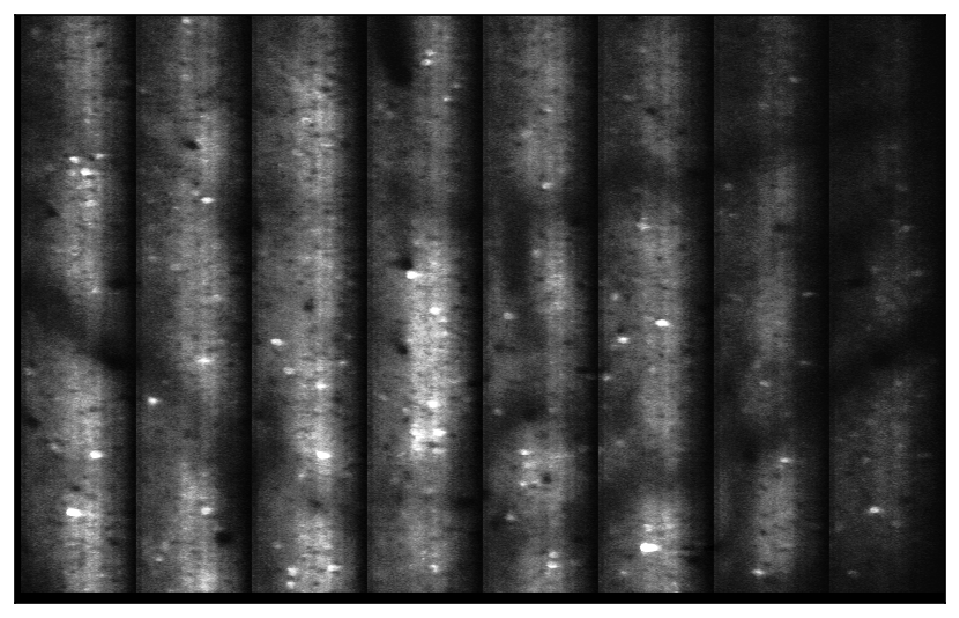

In [56]:
tfu.show_tif(summary['ref_img_3d'][30], vminmax_percentile=(0,99.9))

In [39]:
nbui.ImageSliceViewer3D(summary['ref_img_3d'])

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [41]:
job.register()

      Found dir /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/registered_fused_data
   Updated main params file
   Starting registration: 3D: False, GPU: True
Will analyze 20 tifs in 20 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 127.605 GB, Virtual Available: 391.276 GB, Virtual Used: 111.920 GB, Swap Used: 015.686 GB
Loading Batch 0 of 19
   Loaded movie of size: (40, 270, 500, 800)
LOADED
CONCATENATED
   Loaded 1 files, total 32.19 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 203.637 GB, Virtual Available: 315.244 GB, Virtual Used: 187.951 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 260.439 GB, Virtual Available: 258.442 GB, Virtual Used: 244.753 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 251.590 GB, V

In [46]:
%%time
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 0.5
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/corrmap
   Updated main params file
   Computing correlation map of movie with 5400 frames, volume shape: 40, 509, 805
      Running batch 1 of 27
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 27
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 27
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 4 of 27
         Loading movie into shared memory
   

In [47]:
corr_map = job.load_corr_map_results()['vmap']

corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

In [ ]:
%%time
job.params['peak_thresh'] = 0.15
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3

job.params['n_proc_detect'] = 32
# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map_thresh.copy())

      Found dir /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/segmentation and /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 54
      Found dir /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/segmentation/patch-0000
         Loading 11.59 GB movie to memory, shape: (5400, 40, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.150 and Th2: 5.000
         Iter 0000: running 32 ROIs in parallel
         Added cell 1 at 39, 018, 072, peak: 2.350, thresh: 5.000, 1789 frames, 790 pixels
         Added cell 2 at 39, 017, 045, peak: 1.897, thresh: 5.000, 1908 frames, 

In [52]:
seg = job.load_segmentation_results()
shape = seg['info']['vmap'].shape
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], shape, lam_max=0.1, cmap='Set1')
nbui.ImageSliceViewer3D(corr_map_thresh,cmap='Greys',vminmax=(job.params['peak_thresh'],job.params['peak_thresh']*2), overlay=rgb_vol, alpha=0.5)

      Loading from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/info.npy
      Loading from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [50]:
seg = job.load_segmentation_results()
shape = seg['info']['vmap'].shape
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], shape, lam_max=0.1, cmap='Set1')
nbui.ImageSliceViewer3D(corr_map_thresh,cmap='Greys',vminmax=(job.params['peak_thresh'],job.params['peak_thresh']*2), overlay=rgb_vol, alpha=1.0)

      Loading from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/info.npy
      Loading from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [51]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])



traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

   Updated main params file
   Movie shape: (40, 5400, 509, 805)
6423
   Extracting 6423 valid cells, and saving cell flags to /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 11 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-NaJi-GCaMP6sVS/rois
            Extracting batch 0000 of 0011
            Batch size: 30 GB
            Extracting batch 0001 of 0011
            Batch size: 30 GB
            Extracting batch 0002 of 0011
            Batch size: 30 GB
            Extracting batch 0003 of 0011
            Batch size: 30 GB
            Extracting batch 0004 of 0011
            Batch size: 30 GB
            Extracting batch 0005 of 0011
            Batch size: 30 GB
            Extracting batch 0006 of 0011
            Batch size: 30 GB
            Extracting batch 0007 of 0011
            Batch size: 30 GB
            Extracting batch 0008 of 0011
            Batch size: 30 GB
            Extracting batch 00